In [1]:
import sys
sys.path.append('../../libmitigation')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
import pickle
import pprint
import time

In [3]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import qiskit.ignis.mitigation as mit
import qiskit.quantum_info as qi
# from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal, CompleteMeasFitter, TensoredMeasFitter

In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
import qiskit.ignis.mitigation as mit
from qiskit.ignis.mitigation.measurement import tensored_meas_cal, TensoredMeasFitter
from qiskit.result import Result
import importlib
from inv_sgs import InvSGS
from inv_s_sgs import InvSSGS
from inv_lm_sgs import InvLMSGS
from inv_s_lm_sgs import InvSLMSGS
from inv_s_lm0_sgs import InvSLM0SGS
from inv_s_lmk_sgs import InvSLMkSGS
from mooney_etal import MooneyEtal
from sgs_algorithm import sgs_algorithm
from lib_grover import *
from qiskit.compiler import transpile

In [5]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')
print(provider)

<AccountProvider for IBMQ(hub='ibm-q-utokyo', group='internal', project='hirashi-jst')>


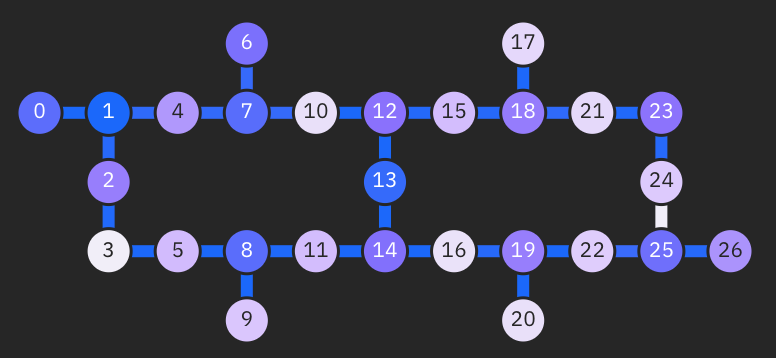

In [6]:
# qubit layout
vertex_list =  [13, # 0
                14, # 1
                12, 16, # 2, 3
                11, 10, 19, # 4, 5, 6
                15,  8,  7, 22, # 7, 8, 9, 10
                20, 18,  5,  4, 25, # 11, 12, 13, 14, 15
                 9,  6,  21, 3,  1, 24, # 16, 17, 18, 19, 20, 21
                17, 26, 23,  2,  0] # 22, 23, 24, 25, 26
def is_permutation(seq):
    return len(seq) == len(set(seq))
assert is_permutation(vertex_list)
max_size = len(vertex_list) # largest graph size
shots_per_circuit = 1 << 13 # shots per one execution
system_size = len(vertex_list)

In [7]:
print("max_size:", max_size)
print("system_size:", system_size)
print("shots_per_circuit:", shots_per_circuit)

max_size: 27
system_size: 27
shots_per_circuit: 8192


In [8]:
# indicate how to connect qubits
order = [[0,1], # 2
         [0,2],  [1,3], # 3
         [1,4],  [2,5],  [3,6], # 4
         [2,7],  [4,8],  [5,9],  [6,10], # 5
         [6,11], [7,12], [8,13], [9,14], [10,15], # 6
         [8,16], [9,17], [12,18],[13,19],[14,20],[15,21], # 7
         [12,22],[15,23],[18,24],[19,25],[20,26]] # 8

In [9]:
qubit_depths = [0, 
                1, 
                2, 2,
                3, 3, 3, 
                4, 4, 4, 4, 
                5, 5, 5, 5, 5, 
                6, 6, 6, 6, 6, 6, 
                7, 7, 7, 7, 7]
print(qubit_depths)
print(len(qubit_depths))

[0, 1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7]
27


In [10]:
def ghz_state(size, order, qubit_depths):
    qc = QuantumCircuit(size)
    if size <= 1:
        qc.measure_all()
        return qc
    qc.h(0)
    depth = 0
    for i, j in order:
        if depth != qubit_depths[j]:
            qc.barrier()
            depth += 1
        qc.cx(i, j)
    qc.barrier()
    qc.measure_all()
    return qc

In [11]:
qcs = [ghz_state(size, order[:size-1], qubit_depths[:size]) for size in range(1, max_size+1)]

In [12]:
print([qc.num_qubits for qc in qcs])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


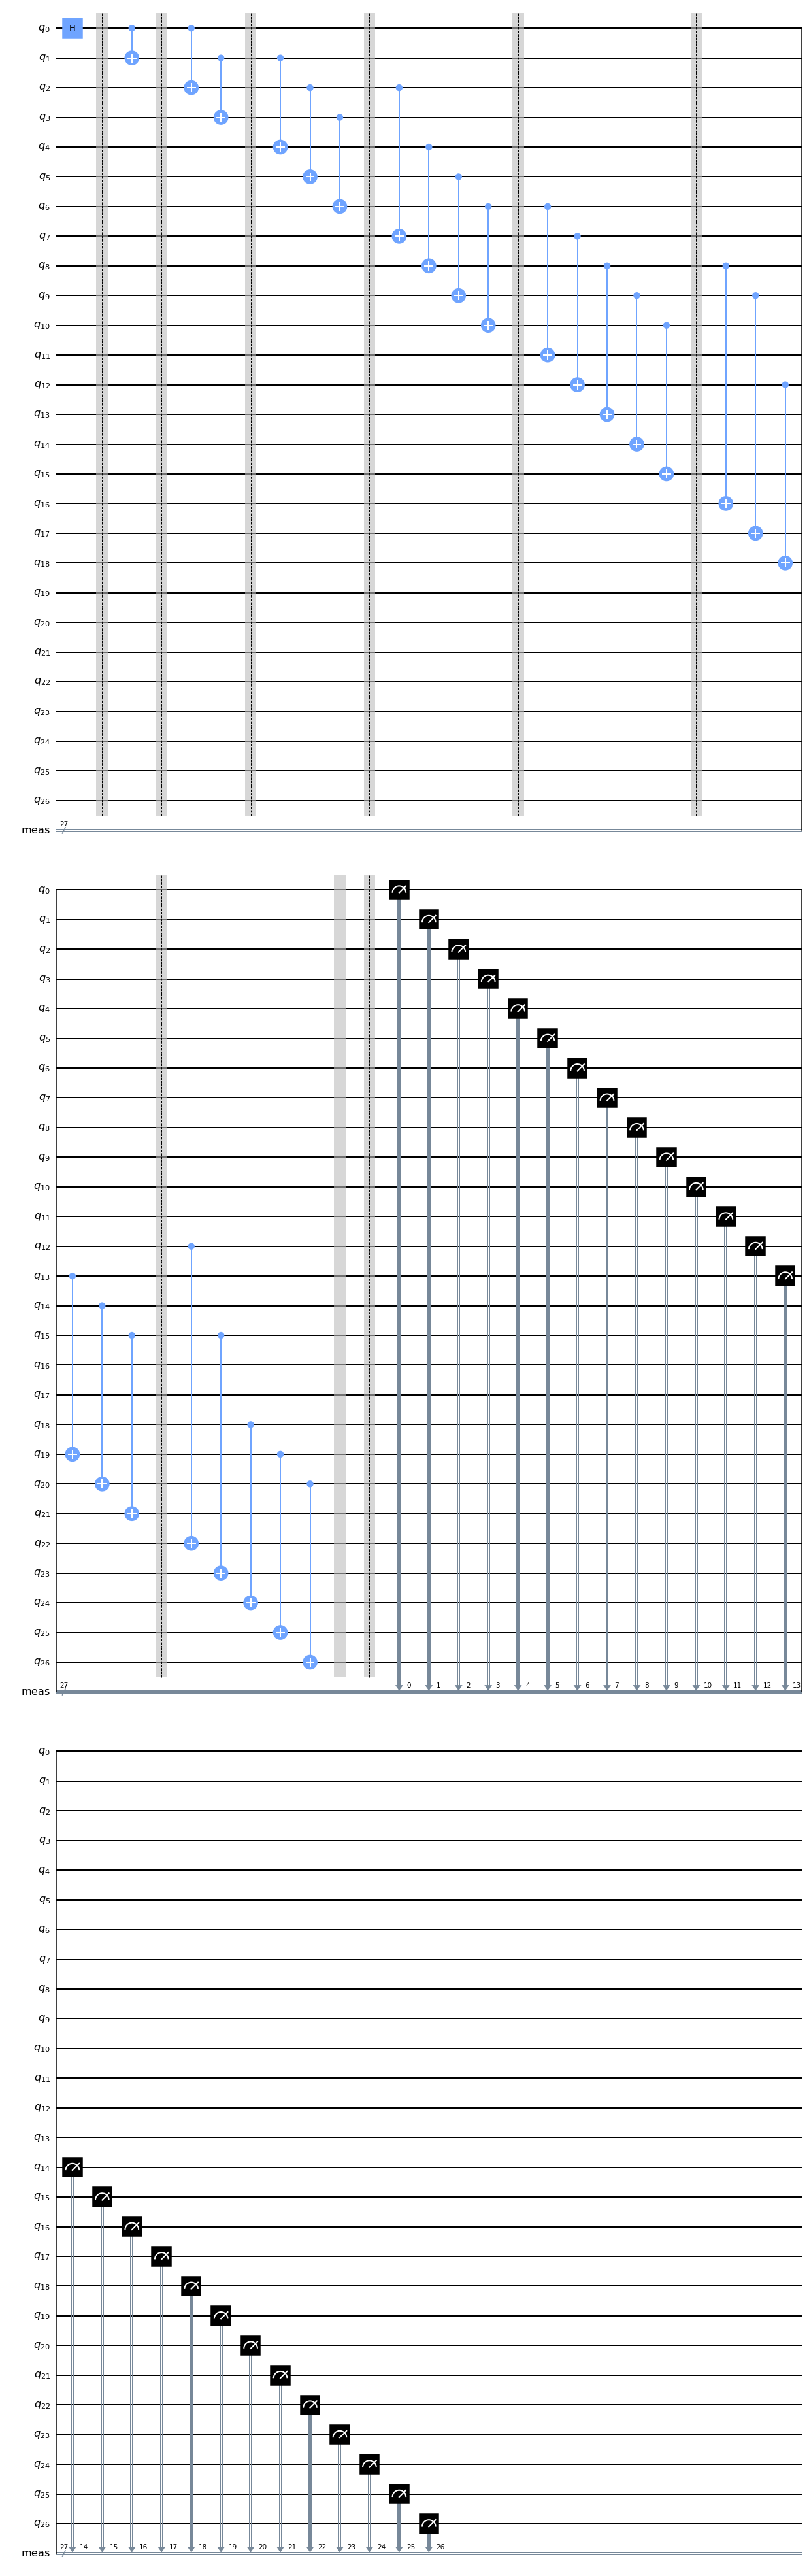

In [13]:
qcs[-1].draw("mpl")

In [14]:
initial_layouts = []
for i in range(len(qcs)):
    initial_layouts.append( vertex_list[:qcs[i].num_qubits] )

In [15]:
device = provider.backend.ibmq_montreal
backend = provider.get_backend('ibmq_montreal')

In [16]:
qr = QuantumRegister(qcs[i].num_qubits)
mit_pattern = [[i] for i in range(qcs[-1].num_qubits)]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')

In [17]:
job_cal = execute(meas_calibs, # qcs_list,
                  backend=backend, 
                  shots=shots_per_circuit, # 8192
                  optimization_level=1,
                  initial_layout=[vertex_list, vertex_list])
print("job id:", job_cal.job_id())

job id: 619eac78580e75441f151041


In [18]:
job = execute(qcs, # qcs_list,
              backend=backend, 
              shots=100,
              optimization_level=1,
              initial_layout=initial_layouts)
print("job id:", job.job_id())

job id: 619eac7c5297ba3a9cece22a


In [19]:
result_cal = job_cal.result()
result = job.result()

In [20]:
meas_fitter = TensoredMeasFitter(result_cal, mit_pattern=mit_pattern)

In [21]:
meas_fitter.cal_matrices

[array([[0.99108887, 0.01147461],
        [0.00891113, 0.98852539]]),
 array([[0.98986816, 0.01916504],
        [0.01013184, 0.98083496]]),
 array([[0.90075684, 0.03271484],
        [0.09924316, 0.96728516]]),
 array([[0.99169922, 0.01245117],
        [0.00830078, 0.98754883]]),
 array([[0.98400879, 0.01782227],
        [0.01599121, 0.98217773]]),
 array([[0.98962402, 0.02404785],
        [0.01037598, 0.97595215]]),
 array([[0.98376465, 0.01428223],
        [0.01623535, 0.98571777]]),
 array([[0.93640137, 0.02404785],
        [0.06359863, 0.97595215]]),
 array([[0.95471191, 0.05285645],
        [0.04528809, 0.94714355]]),
 array([[0.91491699, 0.06738281],
        [0.08508301, 0.93261719]]),
 array([[0.97021484, 0.0255127 ],
        [0.02978516, 0.9744873 ]]),
 array([[0.99328613, 0.01245117],
        [0.00671387, 0.98754883]]),
 array([[0.97180176, 0.04370117],
        [0.02819824, 0.95629883]]),
 array([[0.97619629, 0.01220703],
        [0.02380371, 0.98779297]]),
 array([[0.98376465,